In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from scipy import stats
from sklearn import svm

In [98]:
from transformers import AutoTokenizer, AutoModel
from bert_transformer import BertTransformer

tokenizer = AutoTokenizer.from_pretrained('allegro/herbert-base-cased')
bert_model = AutoModel.from_pretrained("allegro/herbert-base-cased") 

Some weights of the model checkpoint at allegro/herbert-base-cased were not used when initializing BertModel: ['cls.sso.sso_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.sso.sso_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [99]:
X_string = 'nlp_3', #tuple
Y_string = 'GDT_score'
DATASET = 'NLP_FULLSTOPS.xlsx'

In [100]:
df = pd.read_excel(io=DATASET)

bert_transformer = BertTransformer(tokenizer, bert_model, max_length=60)

In [101]:
all_x = []

for item in X_string:

    item_processed = bert_transformer.transform(list(df[item]))
    all_x.append(item_processed)
    print(f'{item} added to list')
    time.sleep(0.5)

all_x = tuple(all_x)
X = np.hstack(all_x)

y = df[Y_string]
X.shape

nlp_3 added to list


(522, 768)

In [102]:
pilot_df = pd.read_excel('NLP_PILOT.XLSX')

pilot_X = []

for item in X_string:

    item_processed = bert_transformer.transform(list(pilot_df[item]))
    pilot_X.append(item_processed)
    print(f'{item} added to list')
    time.sleep(0.5)

pilot_X = tuple(pilot_X)
pilot_X = np.hstack(pilot_X)

pilot_Y = pilot_df[Y_string]
pilot_X.shape

nlp_3 added to list


(95, 768)

In [103]:
SVR_function = svm.SVR(kernel='linear', C=0.1, tol=1e-3)

In [114]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=10, shuffle=True, random_state=1)

true_data = []
results = []


for train_index, test_index in kfold.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

   
    vector_regression = SVR_function
    vector_regression.fit(X_train, y_train)
    result = vector_regression.predict(X_test)

    result = [float(item) for item in result]
    results = np.concatenate((results, result))
    true_data = np.concatenate((true_data, y_test))

    print(stats.pearsonr(result, y_test))


53
PearsonRResult(statistic=0.3486164610198975, pvalue=0.010519822850463581)
106
PearsonRResult(statistic=0.351887209125467, pvalue=0.009768684811244006)
158
PearsonRResult(statistic=0.1592799183750328, pvalue=0.25936995337199786)
210
PearsonRResult(statistic=0.4190050063285857, pvalue=0.001990396284546891)
262
PearsonRResult(statistic=0.3652412837337493, pvalue=0.007757655700753494)
314
PearsonRResult(statistic=0.3202665039466328, pvalue=0.02063104044329142)
366
PearsonRResult(statistic=0.31742356842041436, pvalue=0.02184892546478321)
418
PearsonRResult(statistic=0.49152323547401855, pvalue=0.00021531210050289312)
470
PearsonRResult(statistic=0.37456988449666684, pvalue=0.0062232814063364625)
522
PearsonRResult(statistic=0.3481790727932053, pvalue=0.011425321535061603)


In [116]:
#WHOLE DATASET

results = [item if item >= 4 else 4 for item in results]
results = [item if item <= 20 else 20 for item in results]

print(stats.pearsonr(results, true_data))

PearsonRResult(statistic=0.35149328718768, pvalue=1.2632049159281833e-16)


In [117]:
answers_tuples = [(y, res) for y, res in zip(y, results)]
sorted_tuples = sorted(answers_tuples, key=lambda x: x[0])

test_y = [x[0] for x in sorted_tuples]
result = [x[1] for x in sorted_tuples]

rounded_result = [round(item) for item in result]

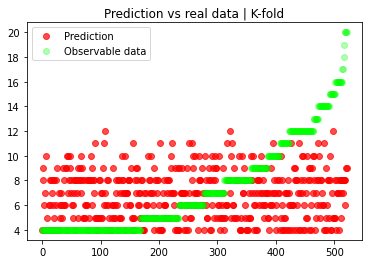

In [118]:
plt.plot(range(len(result)), rounded_result, 'o', color=[1, 0, 0, 0.7], label="Prediction")
plt.plot(range(len(test_y)), test_y, 'o', color=[0, 1, 0, 0.3], label='Observable data')
plt.legend(loc='upper left')
plt.title('Prediction vs real data | K-fold')
plt.show()

In [119]:
# Using model to predict pilot data

vector_regression_pilot = SVR_function
vector_regression_pilot.fit(X, y)

SVR(C=0.1, kernel='linear')

In [120]:
prediction = vector_regression_pilot.predict(pilot_X)
prediction = [float(item) for item in prediction]

results = [item if item >= 4 else 4 for item in prediction]
results = [item if item <= 20 else 20 for item in results]

print(stats.pearsonr(results, pilot_Y))

PearsonRResult(statistic=0.2498159721138381, pvalue=0.014625756953485338)


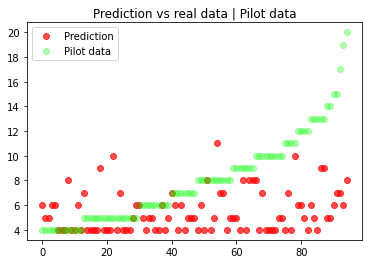

In [121]:
answers_tuples = [(y, res) for y, res in zip(pilot_Y, results)]
sorted_tuples = sorted(answers_tuples, key=lambda x: x[0])

test_y = [x[0] for x in sorted_tuples]
result = [x[1] for x in sorted_tuples]

rounded_result = [round(int(item)) for item in result]

plt.plot(range(len(result)), rounded_result, 'o', color=[1, 0, 0, 0.7], label="Prediction")
plt.plot(range(len(test_y)), test_y, 'o', color=[0, 1, 0, 0.3], label='Pilot data')
plt.legend(loc='upper left')
plt.title('Prediction vs real data | Pilot data')
plt.show()